# Machine Learning Model To Forecast Future Sales OF Stores

In [1]:
# Importing all the required packages.
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRFRegressor
import pickle
import warnings
warnings.filterwarnings('ignore')

# Loading the training data into the notebook

In [2]:
df = pd.read_csv('data/data.csv',index_col=0)
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,DayOfMonth,weekday
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,0,2015,7,31,1
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,0,2015,7,30,1
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,0,2015,7,29,1
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,0,2015,7,28,1
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,0,2015,7,27,1


In [3]:
# Filtering the data where stores were open and sales took place.
df = df[(df['Open'] == 1) & (df['Sales'] > 0)]

In [5]:
# Dropping Weekday column to avoid duplication of records as DayOfWeek column is already present in the data 
df.drop('weekday',axis=1,inplace=True)

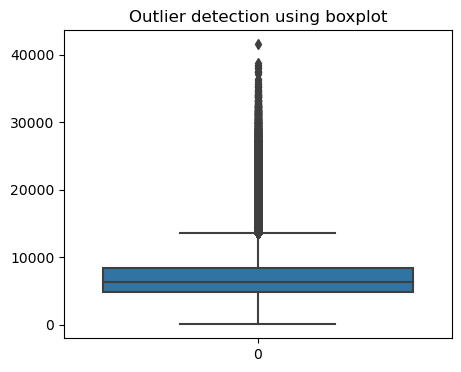

In [6]:
# Identifying the Outliers in the Sales column (Target feature)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,4))
sns.boxplot(df['Sales'])
plt.title('Outlier detection using boxplot')
plt.show()

In [7]:
# Treating the outliers using Inter Quartile Range method
q1 = df['Sales'].quantile(0.25)
q3 = df['Sales'].quantile(0.75)
IQR=q3-q1
    
lower = q1-1.5*IQR
upper = q3+1.5*IQR
df['Sales']=np.where(df['Sales']>upper,upper,np.where(df['Sales']<lower,lower,df['Sales']))

In [8]:
# Separating Independent and dependent or target feature for model building
x = df[['Store','DayOfWeek','Promo','StateHoliday','SchoolHoliday','StoreType','Assortment','CompetitionDistance','Year','Month','DayOfMonth']]
y = np.log(df['Sales'])

In [9]:
# Transforming the categorical data into continuous data as Machine learning models take input in numerical format.
mapping1 = {'a': 1, 'b': 2, 'c': 3, 'd': 4}
x['StoreType'] = x['StoreType'].replace(mapping1)

mapping2 = {'a': 1, 'b': 2, 'c': 3}
x['Assortment'] = x['Assortment'].replace(mapping2)

mapping3 = {'0': 0, 'a': 1, 'b': 2, 'c': 3}
x['StateHoliday'] = x['StateHoliday'].replace(mapping3)

In [10]:
# Creating 80% data as training data and 20% as test data to evaluate the model performance
x_train = x.iloc[:int(0.8*len(x)),:]
y_train = y.iloc[:int(0.8*len(y))]
x_test = x.iloc[int(0.8*len(x)):,:]
y_test = y.iloc[int(0.8*len(y)):]

In [11]:
# Normalising the data using MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [12]:
# Function to calculate Mean Absolute Percentage Accuracy to evaluate the performance of forecasting model
def MAPE(y_actual,y_predicted):
    error_perc = round(np.mean(np.abs((y_actual - y_predicted) / y_actual)) * 100,2)
    map_accuracy = 100 - error_perc
    return map_accuracy

# RandomForest Regressor

In [13]:
rf = RandomForestRegressor(max_depth=12, max_features=0.2, max_samples=0.75,
                      n_estimators=120)

rf.fit(x_train,y_train)
rf_pred = rf.predict(x_test)
print('Mean Absolute Percentage Accuracy for RandomForest Model is ', round(MAPE(np.exp(y_test),np.exp(rf_pred)),2),'%','\n')



Mean Absolute Percentage Accuracy for RandomForest Model is  73.13 % 



# KNearest Neighbors Regressor

In [14]:
knn = KNeighborsRegressor(n_neighbors = 400)
knn.fit(x_train,y_train)
knn_pred = knn.predict(x_test)
print('Mean Absolute Percentage Accuracy for K Nearest Neighbors model is ', round(MAPE(np.exp(y_test),np.exp(knn_pred)),2),'%','\n')

Mean Absolute Percentage Accuracy for K Nearest Neighbors model is  72.13 % 



# XGBoost Regressor

In [15]:
xgb = XGBRFRegressor(n_estimators = 150,learning_rate=1,random_state=42)
xgb.fit(x_train,y_train)
xgb_pred = xgb.predict(x_test)
print('acc', MAPE(np.exp(y_test),np.exp(xgb_pred)),'%','\n')

[16:59:01] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
acc 71.27 % 



In [18]:
# Creating model dataframe to compare perforamcne of different models
Model_df = pd.DataFrame({
    'Model_name': ['RandomForest','KNearest_Neighbors','XGBoost_Regressor'],
    'Mean Absolute Percentage Accuracy': [73.13,72.13,71.27]
})

Model_df

,Model_name,Mean Absolute Percentage Accuracy
0,RandomForest,73.13
1,KNearest_Neighbors,72.13
2,XGBoost_Regressor,71.27


<Axes: >

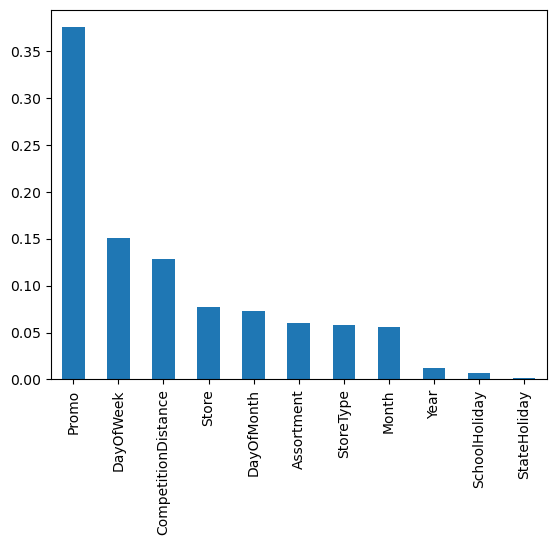

In [19]:
# Feature Importance of Randomforest Regressor

features = pd.Series(rf.feature_importances_,x.columns).sort_values(ascending=False)
features.plot(kind='bar')

# Future sales forecast for the test data using the RandomForest Regressor

In [28]:
# Loading the test data
test_df = pd.read_csv('data/test_data.csv',index_col=0)
test_df.head(3)

,Store,Date,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Month,DayOfMonth
0,1,2015-09-17,1,0,0,3,1,1270.0,9,17
1,1,2015-09-16,1,0,0,3,1,1270.0,9,16
2,1,2015-09-15,1,0,0,3,1,1270.0,9,15


In [29]:
# Processing the test data to be given as input to the model
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df['Year'] = test_df['Date'].dt.year
test_df['Dayofweek'] = test_df['Date'].dt.day_of_week
test_df.drop(['Date'],axis=1,inplace=True)

In [31]:
# Transforming the test datafrane into a numpy array and making predictions
test_array = test_df.to_numpy()
test_sales = np.exp(rf.predict(test_array))

In [32]:
test_df['Predicted Sales'] = test_sales

In [34]:
# Future sales for the given test data
test_df['Predicted Sales'] = test_df['Predicted Sales'].astype(int)
test_df

,Store,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Month,DayOfMonth,Year,Dayofweek,Predicted Sales
0,1,1,0,0,3,1,1270.0,9,17,2015,3,4594
1,1,1,0,0,3,1,1270.0,9,16,2015,2,4594
2,1,1,0,0,3,1,1270.0,9,15,2015,1,4594
3,1,1,0,0,3,1,1270.0,9,14,2015,0,5753
5,1,0,0,0,3,1,1270.0,9,12,2015,5,6034
...,...,...,...,...,...,...,...,...,...,...,...,...
41082,1115,1,0,1,4,3,5350.0,8,6,2015,3,4452
41083,1115,1,0,1,4,3,5350.0,8,5,2015,2,4452
41084,1115,1,0,1,4,3,5350.0,8,4,2015,1,4452
41085,1115,1,0,1,4,3,5350.0,8,3,2015,0,5380


# Saving the test data with future sales and the RandomForest Regressor model

In [35]:
test_df.to_csv('data/test_df.to_csv')

In [36]:
pickle.dump(rf,open('MLmodel.pkl','wb'))